# Mask R-CNN - Inspect Trained Model

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import utils, gen_cocodb
import visualize
from visualize import display_images
import libs.nets.model as modellib
from libs.nets.model import log
from libs.configs import config

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "output/models")
print(MODEL_DIR)

/home/tj/workspace/Instance-Segmentation/output/models


# Configurations

In [2]:
# MS COCO Dataset
import train
config = train.CocoConfig()
COCO_DIR = os.path.join(ROOT_DIR, 'data/coco')

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING     

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/device:CPU:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Load Validation Dataset

In [5]:
print('dataset_path: ', COCO_DIR)
coco_val = gen_cocodb.CocoDataSet()
coco_val.load_coco(COCO_DIR, "minival", year="2014", auto_download=False)
coco_val.prepare()
print("Images: {}\nClasses: {}".format(len(coco_val.image_ids), coco_val.class_names))
image_id = random.choice(coco_val.image_ids)

gt_image, image_meta, gt_class_id, gt_bbox, gt_mask = coco_val.load_image_gt(coco_val, config, image_id, use_mini_mask=False)
info = coco_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       coco_val.image_reference(image_id)))
print(gt_image.shape, image_meta.shape)

image = coco_val.load_image(image_id)
images = np.expand_dims(image, axis=0)
molded_images, image_metas, windows = gen_cocodb.mold_inputs(images, config)
print(image.shape, molded_images.shape, image_metas.shape, windows.shape)

anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                             config.RPN_ANCHOR_RATIOS,
                                             config.BACKBONE_SHAPES,
                                             config.BACKBONE_STRIDES,
                                             config.RPN_ANCHOR_STRIDE)

('dataset_path: ', '/home/tj/workspace/Instance-Segmentation/data/coco')
loading annotations into memory...
Done (t=5.50s)
creating index...
index created!
/home/tj/workspace/Instance-Segmentation/data/coco/val2014
Images: 40137
Classes: ['BG', u'person', u'bicycle', u'car', u'motorcycle', u'airplane', u'bus', u'train', u'truck', u'boat', u'traffic light', u'fire hydrant', u'stop sign', u'parking meter', u'bench', u'bird', u'cat', u'dog', u'horse', u'sheep', u'cow', u'elephant', u'bear', u'zebra', u'giraffe', u'backpack', u'umbrella', u'handbag', u'tie', u'suitcase', u'frisbee', u'skis', u'snowboard', u'sports ball', u'kite', u'baseball bat', u'baseball glove', u'skateboard', u'surfboard', u'tennis racket', u'bottle', u'wine glass', u'cup', u'fork', u'knife', u'spoon', u'bowl', u'banana', u'apple', u'sandwich', u'orange', u'broccoli', u'carrot', u'hot dog', u'pizza', u'donut', u'cake', u'chair', u'couch', u'potted plant', u'bed', u'dining table', u'toilet', u'tv', u'laptop', u'mouse', 

# Load Model

In [6]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR, anchors=anchors )

feed_dict = {model.input_image: molded_images, model.input_image_meta: image_metas}

detections = model.outputs['detections']
mrcnn_class = model.outputs['mrcnn_class']
mrcnn_bbox = model.outputs['mrcnn_bbox']
mrcnn_mask = model.outputs['mrcnn_mask']

('is_training', False)
(?, 512, 512, 32)
(?, 256, 256, 128)
(?, 128, 128, 256)
(?, 64, 64, 512)
(?, 32, 32, 1024)
(1000, <tf.Tensor 'RPN/rpn_class:0' shape=(?, ?, 2) dtype=float32>)
('rpn_rois', <tf.Tensor 'proposals:0' shape=(1, 1000, 4) dtype=float32>)
1000
======== fpn_classifier_graph ============
Tensor("mrcnn/GatherV2_1:0", shape=(?, 7, 7, 256), dtype=float32, device=/device:CPU:0)
('fpn_classifier_graph', <tf.Tensor 'proposals:0' shape=(1, 1000, 4) dtype=float32>, <tf.Tensor 'mrcnn/Reshape:0' shape=(1, 1000, 81) dtype=float32>, <tf.Tensor 'mrcnn/mrcnn_bbox:0' shape=(1, 1000, 81, 4) dtype=float32>)
('detections', <tf.Tensor 'mrcnn/PyFunc:0' shape=<unknown> dtype=float32>)
======== build_fpn_mask_graph ============
('mrcnn_mask', <tf.Tensor 'mrcnn/Reshape_3:0' shape=(?, 100, 28, 28, 81) dtype=float32>)


# Run Detection

INFO:tensorflow:Restoring parameters from /home/tj/workspace/Instance-Segmentation/output/models/mrcnn_final.ckpt
('ckpt_path', u'/home/tj/workspace/Instance-Segmentation/output/models/mrcnn_final.ckpt')
INFO:tensorflow:Restoring parameters from /home/tj/workspace/Instance-Segmentation/output/models/mrcnn_final.ckpt
((1, 1000, 4), (1, 1000, 81), (1, 1000, 81, 4), (1, 89))
((1000, 4), (1000, 81), (1000, 81, 4), (4,))
((1, 100, 6), (1, 1000, 81), (1, 1000, 81, 4), (1, 100, 28, 28, 81))
pre_nms_anchors          shape: (1, 6000, 4)          min: -234.03867  max: 1258.03870
refined_anchors          shape: (1, 6000, 4)          min: -188.50061  max: 1250.64502
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max: 1024.00000
rpn_non_max_suppression  shape: (1000,)               min:    0.00000  max: 3794.00000
rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max: 

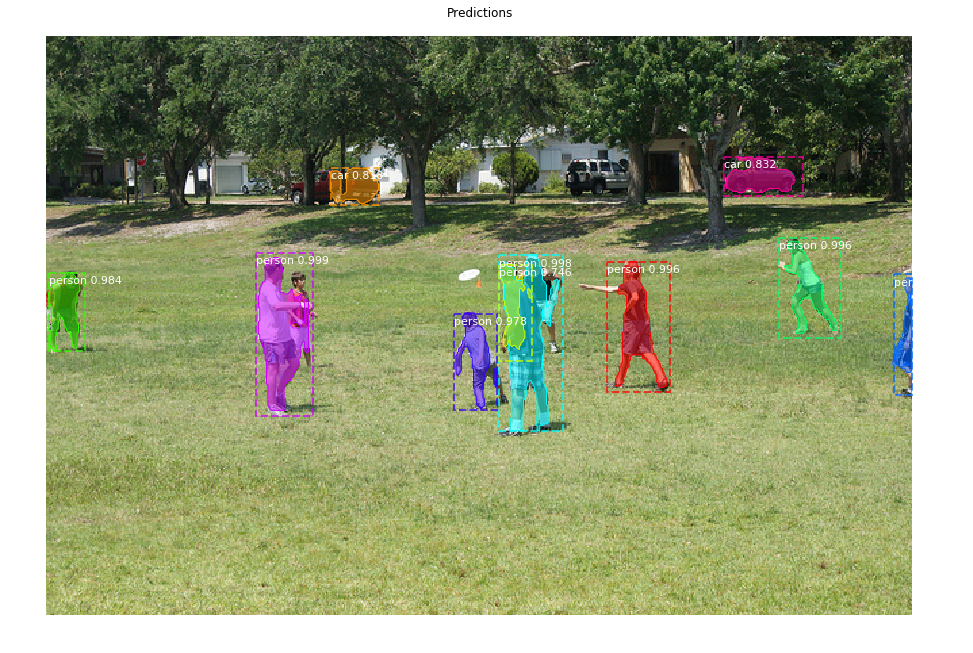

In [7]:
saver = tf.train.Saver()
init_op = tf.global_variables_initializer()
with tf.device(DEVICE):
    with tf.Session() as sess:
        sess.run(init_op)
        ckpt = tf.train.get_checkpoint_state(MODEL_DIR)
        """ resotre checkpoint of Backbone network """
        if ckpt is not None:
            ckpt_path = tf.train.latest_checkpoint(MODEL_DIR)
            saver.restore(sess, ckpt_path)
        else:
            ckpt_path = FLAGS.checkpoint_model
            saver.restore(sess, ckpt_path)
        print('ckpt_path', ckpt_path)
        
        saver.restore(sess, ckpt_path)

        rpn_targets = []
        # For RPN Prediction
        rpn_targets.append(sess.graph.get_tensor_by_name("pre_nms_anchors:0"))
        rpn_targets.append(sess.graph.get_tensor_by_name("refined_anchors:0"))
        rpn_targets.append(sess.graph.get_tensor_by_name("refined_anchors_clipped:0"))
        rpn_targets.append(sess.graph.get_tensor_by_name("rpn_non_max_suppression/NonMaxSuppressionV3:0"))
        rpn_targets.append(sess.graph.get_tensor_by_name("RPN/rpn_class:0"))
        rpn_targets.append(sess.graph.get_tensor_by_name("proposals:0"))
        
        detect, pred_class, pred_bbox, pred_mask, rpn_target = sess.run([detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, rpn_targets],
                                                            feed_dict=feed_dict)

        print(detect.shape, pred_class.shape, pred_bbox.shape, pred_mask.shape)
        
        # For RPN Prediction outputs
        pre_nms_anchors = rpn_target[0]
        refined_anchors =  rpn_target[1]
        refined_anchors_clipped =  rpn_target[2]
        rpn_non_max_suppression =  rpn_target[3]
        rpn_class =  rpn_target[4]
        proposals =  rpn_target[5]
        log("pre_nms_anchors", pre_nms_anchors)
        log("refined_anchors", refined_anchors)
        log("refined_anchors_clipped", refined_anchors_clipped)
        log("rpn_non_max_suppression", rpn_non_max_suppression)
        log("rpn_class", rpn_class)
        log("proposals", proposals)
        
        

        # Process detections
        results = []
        final_rois, final_class_ids, final_scores, final_masks = gen_cocodb.unmold_detections(detect[0],
                                                                                              pred_mask[0],
                                                                                              image.shape,
                                                                                              windows[0])
        
        print(image.shape, final_rois[0])

        ax = get_ax(1)
        visualize.display_instances(image, final_rois, final_masks, final_class_ids,
                                    coco_val.class_names, final_scores, ax=ax,
                                    title="Predictions")

# Precision-Recall

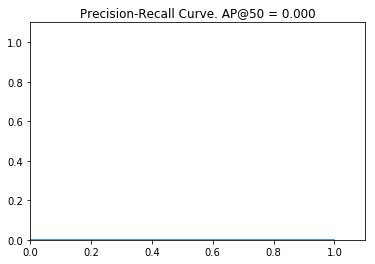

In [8]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, 
                                                     final_rois, final_class_ids, final_scores)
visualize.plot_precision_recall(AP, precisions, recalls)

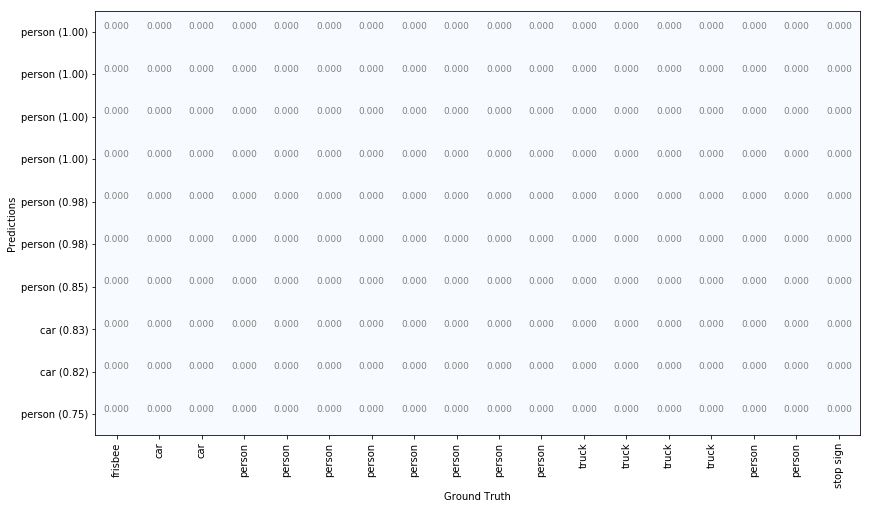

In [9]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, final_class_ids, final_scores,
                        overlaps, coco_val.class_names)

# Step 1 : RPN

In [10]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = utils.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
target_refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", target_refined_anchors, )

target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -7.54862  max:    5.96621
positive_anchors         shape: (28, 4)               min:  196.68629  max:  835.31371
negative_anchors         shape: (228, 4)              min: -170.03867  max: 1322.03867
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867
refined_anchors          shape: (28, 4)               min:  193.00000  max:  832.00000


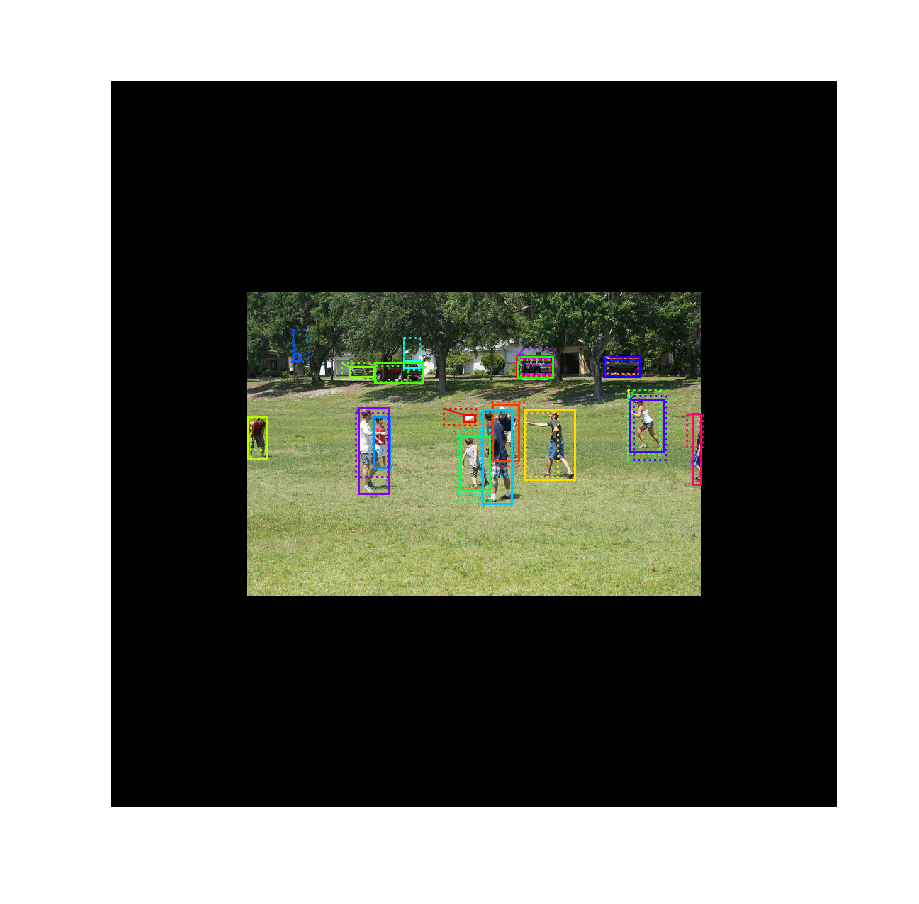

In [11]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(gt_image, boxes=positive_anchors, refined_boxes=target_refined_anchors, ax=get_ax())

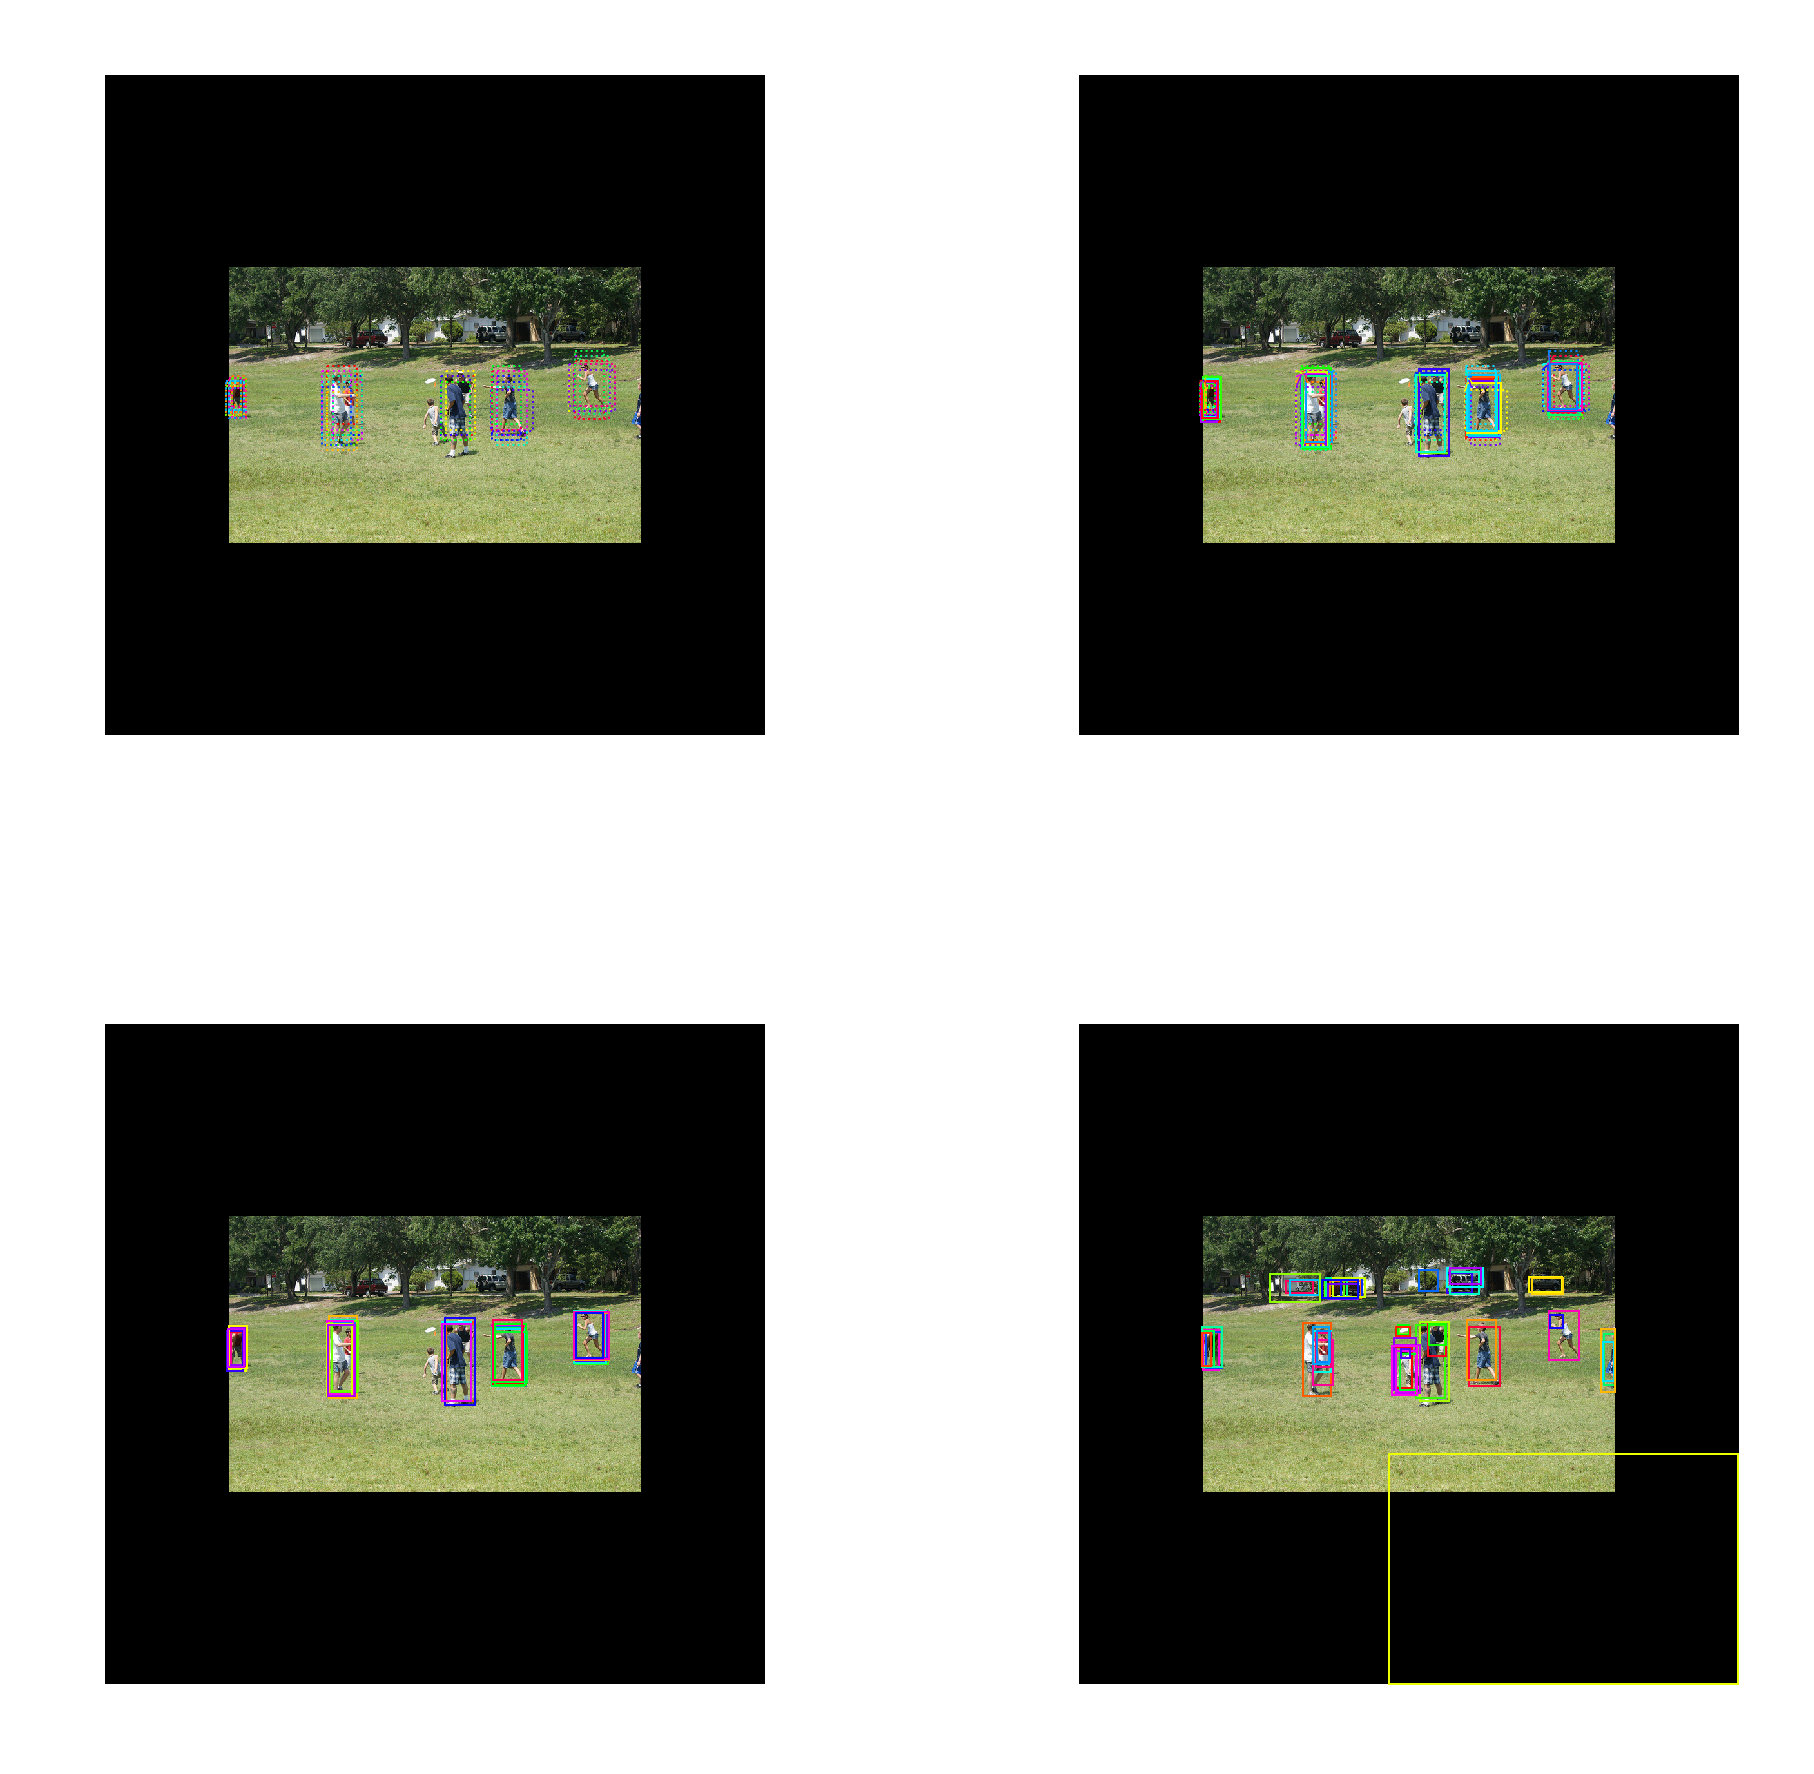

In [12]:
# Show top anchors by score (before refinement)
limit = 50
ax = get_ax(2, 2)
sorted_anchor_ids = np.argsort(rpn_class[:,:,1].flatten())[::-1]
visualize.draw_boxes(gt_image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=ax[0][0])

# Top anchors with refinement
visualize.draw_boxes(gt_image, boxes=pre_nms_anchors[0, :limit], refined_boxes=refined_anchors[0, :limit], ax=ax[0][1])

# Top anchors with refinement with clipping
visualize.draw_boxes(gt_image, refined_boxes=refined_anchors_clipped[0, :limit], ax=ax[1][0])

# refined anchorts after NMS
ixs = rpn_non_max_suppression[:limit]
visualize.draw_boxes(gt_image, refined_boxes=refined_anchors_clipped[0, ixs], ax=ax[1][1])

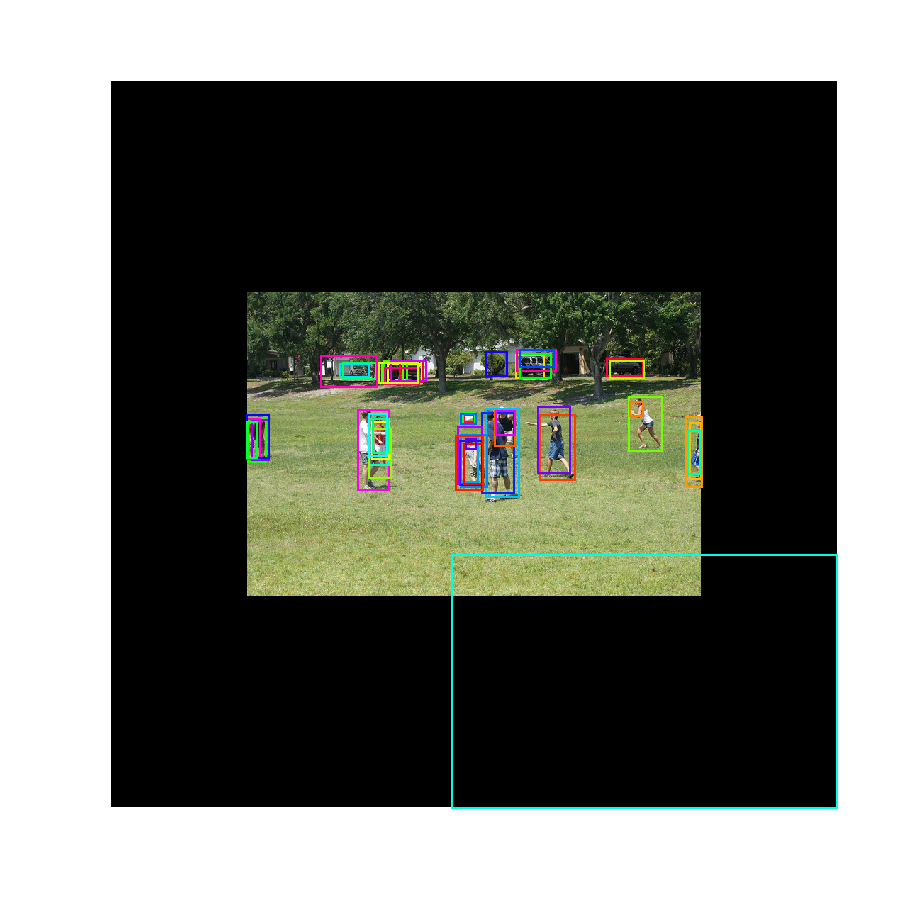

In [13]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
rpn_proposals = proposals[0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(gt_image, refined_boxes=rpn_proposals, ax=get_ax())

# Step 2 : Proposal Classification

In [14]:
print("proposals", proposals.shape)
print("probs", pred_class.shape)
print("deltas", pred_bbox.shape)
print("masks", pred_mask.shape)
print("detections", detect.shape)

('proposals', (1, 1000, 4))
('probs', (1, 1000, 81))
('deltas', (1, 1000, 81, 4))
('masks', (1, 100, 28, 28, 81))
('detections', (1, 100, 6))


10 detections: [u'person' u'person' u'person' u'person' u'person' u'person' u'person'
 u'car' u'car' u'person']


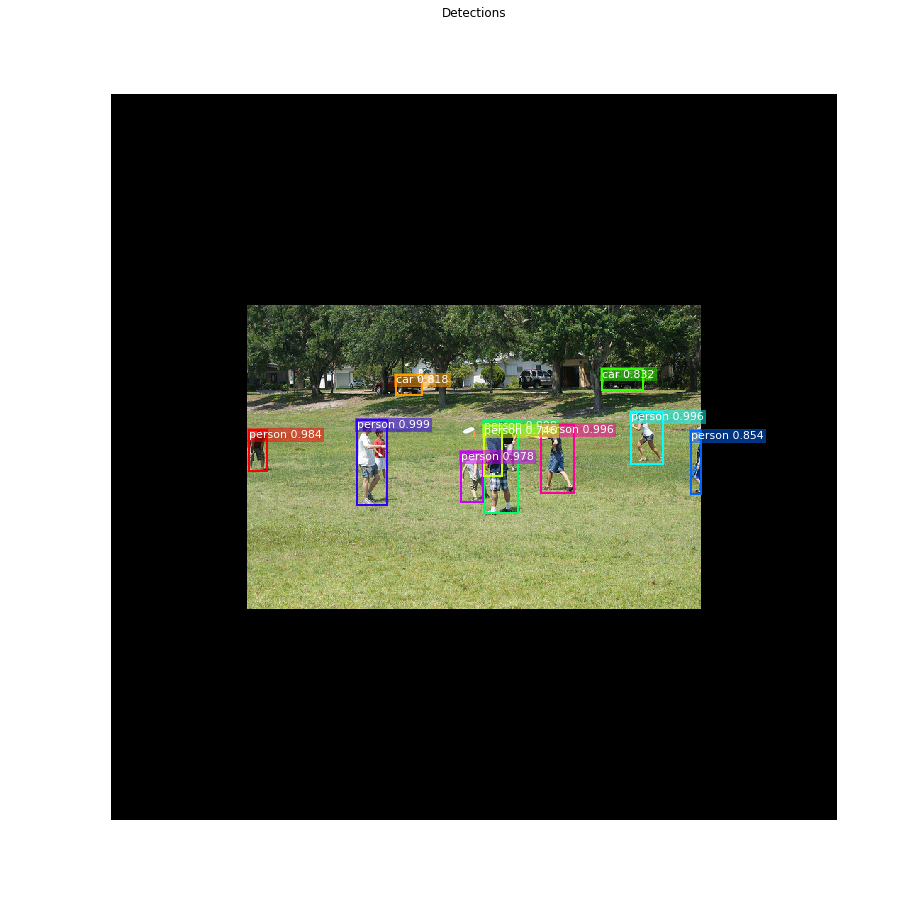

In [15]:
# Get detection class IDs. Trim zero padding.
det_class_ids = detect[0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = detect[0, :det_count]

print("{} detections: {}".format( det_count, np.array(coco_val.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(coco_val.class_names[int(c)], s) if c > 0 else ""
                    for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes( gt_image, 
                     refined_boxes=detections[:, :4],
                     visibilities=[2] * len(detections),
                     captions=captions, title="Detections",
                     ax=get_ax())

# Step 3 : Generating Masks

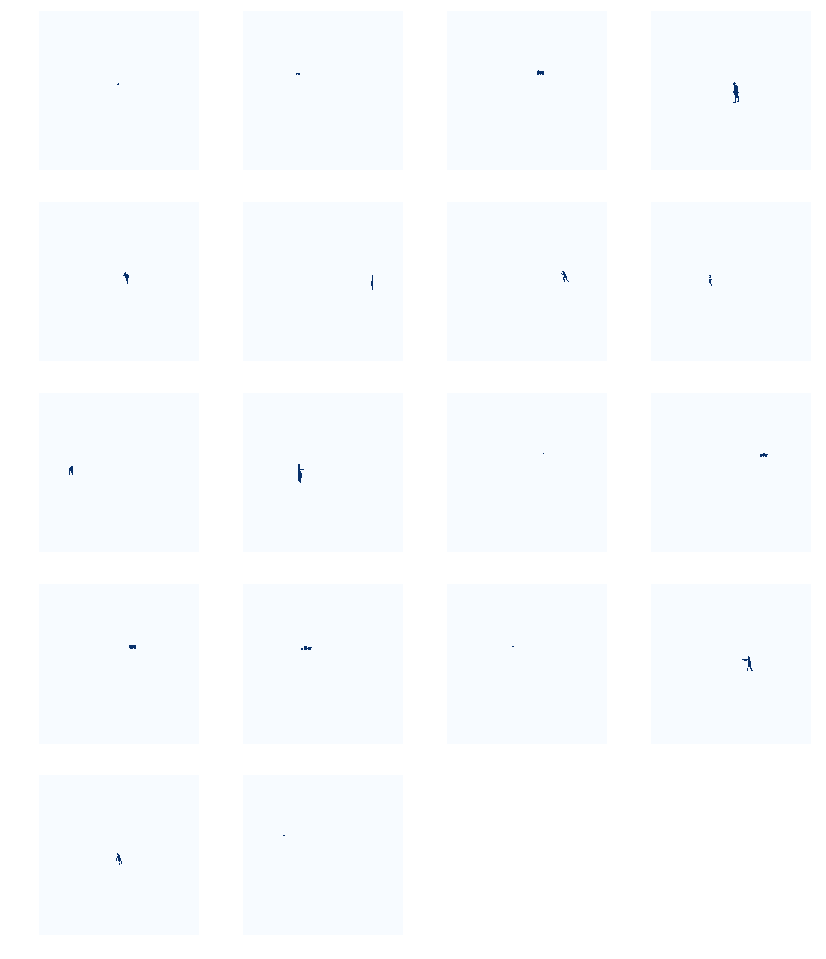

In [16]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

In [17]:
# Get detection class IDs. Trim zero padding.
det_class_ids = detect[0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format( det_count, np.array(coco_val.class_names)[det_class_ids]))

# Masks
det_boxes = detect[0, :, :4].astype(np.int32)
det_mask_specific = np.array([pred_mask[0, i, :, :, c]  for i, c in enumerate(det_class_ids)])
det_masks = np.array([gen_cocodb.unmold_mask(m, det_boxes[i], gt_image.shape) for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

10 detections: [u'person' u'person' u'person' u'person' u'person' u'person' u'person'
 u'car' u'car' u'person']
det_mask_specific        shape: (10, 28, 28)          min:    0.00000  max:    1.00000
det_masks                shape: (10, 1024, 1024)      min:    0.00000  max:    1.00000


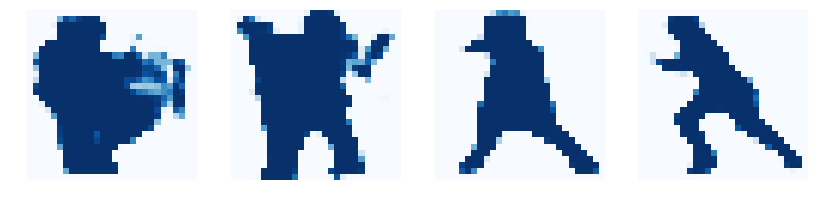

In [18]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

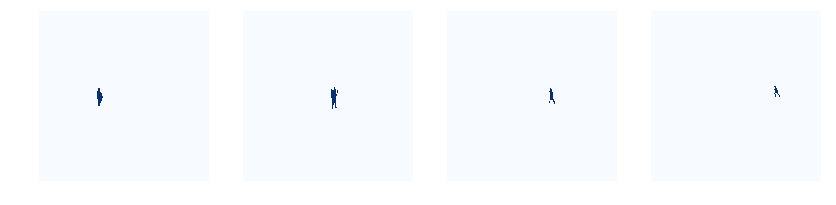

In [19]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")